In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
import torch

In [2]:
path = 'MNIST/train.csv'

In [3]:
train = np.loadtxt(path, delimiter=',', skiprows=1)

train_label = train[:, 0].astype('uint8')

train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28)).astype('uint8')

In [4]:
train_img[0].shape

(28, 28)

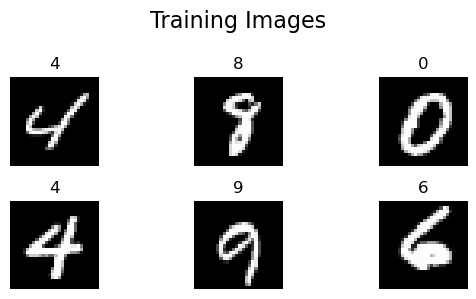

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(6, 3))
axes = axes.flatten()

for i in range(6):
    random_image = random.randint(0,train_img.shape[0]) 
    
    axes[i-1].imshow(train_img[random_image], cmap='gray')
    axes[i-1].set_title(train_label[random_image])
    axes[i-1].axis('off') 

plt.suptitle("Training Images", size=16)
plt.tight_layout()
plt.show()

# Preprocess

In [6]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (14,14)
cellSize = (7,7)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog = cv2.HOGDescriptor(winSize,
                        blockSize,
                        blockStride,
                        cellSize,
                        nbins,
                        derivAperture,
                        winSigma,
                        histogramNormType,
                        L2HysThreshold,
                        gammaCorrection,
                        nlevels)

In [7]:
descriptor = hog.compute(train_img[1324])
print('Descriptor size: %d' % len(descriptor))

Descriptor size: 144


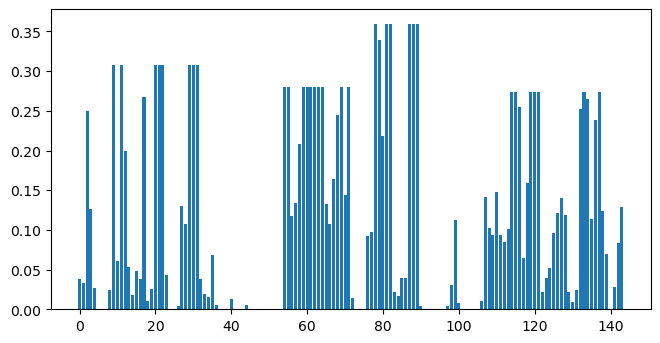

In [8]:
fig = plt.figure(figsize=(6,3))

ax = fig.add_axes([0,0,1,1])
ax.bar(range(len(descriptor)), descriptor.reshape(-1))
plt.show()

In [9]:
def get_and_preprocess_data(data_path, y=None):
    data = np.loadtxt(data_path, delimiter=',', skiprows=1)
    
    if y:
        y = data[:, 0].astype('uint8')
        X = np.resize(data[:, 1:], (data.shape[0], 28, 28)).astype('uint8')
        X = np.array(list(map(hog.compute, X)))
        return map(torch.Tensor, (X, y))
    
    else:
        X = np.resize(data[:, :], (data.shape[0], 28, 28)).astype('uint8')
        X = np.array(list(map(hog.compute, X)))
    
        return torch.Tensor(X)

In [10]:
train_path = 'MNIST/train.csv'
test_path = 'MNIST/test.csv'

train_data, target_data = get_and_preprocess_data(train_path, y=True)
eval_ = get_and_preprocess_data(test_path)

# Prepare data

In [11]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [12]:
loader = {
    'train': DataLoader(train_data,
                        batch_size = 64,
                        shuffle = False,
                        num_workers = 1,
    ),
    'target': DataLoader(target_data,
                        batch_size = 64,
                        shuffle = False,
                        num_workers = 1,
    ),
    'eval_': DataLoader(eval_,
                       batch_size = 64,
                       shuffle = True
    )
}

# Build model

In [13]:
class simpleDense(nn.Module):
    def __init__(self):
        super(simpleDense, self).__init__()
        self.dense1 = nn.Linear(144, 72)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(.3)
        self.dense2 = nn.Linear(72, 36)
        self.dense3 = nn.Linear(36, 10)
        self.softmax = nn.Softmax(0)
            
    def forward(self, x):
        # x = torch.Tensor(hog.compute(np.array(x)))
        out = self.dropout(self.relu(self.dense1(x)))
        out = self.dropout(self.relu(self.dense2(out)))
        out = self.dense3(out)
        return out

model = simpleDense()

In [14]:
print(model)

simpleDense(
  (dense1): Linear(in_features=144, out_features=72, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (dense2): Linear(in_features=72, out_features=36, bias=True)
  (dense3): Linear(in_features=36, out_features=10, bias=True)
  (softmax): Softmax(dim=0)
)


# Train model

In [15]:
optimizer = optim.NAdam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [16]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(zip(loader['train'], loader['target']) ):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.long())
        loss.backward()
        optimizer.step()
        if batch_idx %100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/ {len(loader['train'].dataset)} ({100. * batch_idx/ len(loader['train']):.0f}%)]\t{loss.item():.6f}")

In [17]:
for epoch in range(1,5):
    train(epoch)
    # test()

Train Epoch: 1 [0/ 42000 (0%)]	2.289407
Train Epoch: 1 [6400/ 42000 (15%)]	0.251738
Train Epoch: 1 [12800/ 42000 (30%)]	0.437229
Train Epoch: 1 [19200/ 42000 (46%)]	0.301992
Train Epoch: 1 [25600/ 42000 (61%)]	0.307488
Train Epoch: 1 [32000/ 42000 (76%)]	0.183582
Train Epoch: 1 [38400/ 42000 (91%)]	0.165606
Train Epoch: 2 [0/ 42000 (0%)]	0.185684
Train Epoch: 2 [6400/ 42000 (15%)]	0.093145
Train Epoch: 2 [12800/ 42000 (30%)]	0.240404
Train Epoch: 2 [19200/ 42000 (46%)]	0.246128
Train Epoch: 2 [25600/ 42000 (61%)]	0.183523
Train Epoch: 2 [32000/ 42000 (76%)]	0.222552
Train Epoch: 2 [38400/ 42000 (91%)]	0.119381
Train Epoch: 3 [0/ 42000 (0%)]	0.220535
Train Epoch: 3 [6400/ 42000 (15%)]	0.139151
Train Epoch: 3 [12800/ 42000 (30%)]	0.200844
Train Epoch: 3 [19200/ 42000 (46%)]	0.241593
Train Epoch: 3 [25600/ 42000 (61%)]	0.174118
Train Epoch: 3 [32000/ 42000 (76%)]	0.205540
Train Epoch: 3 [38400/ 42000 (91%)]	0.203126
Train Epoch: 4 [0/ 42000 (0%)]	0.170301
Train Epoch: 4 [6400/ 42000 (15%)

# Eval model

In [18]:
correct = 0
total = 0

with torch.no_grad():
    for x, y in zip(loader['train'], loader['target']):
        output = model(x)
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct +=1
            total +=1
print(f'accuracy: {round(correct/total, 3)}')

accuracy: 0.952


# Kaggle submission

In [20]:
img = cv2.imread('Kaggle_screenshot.png')

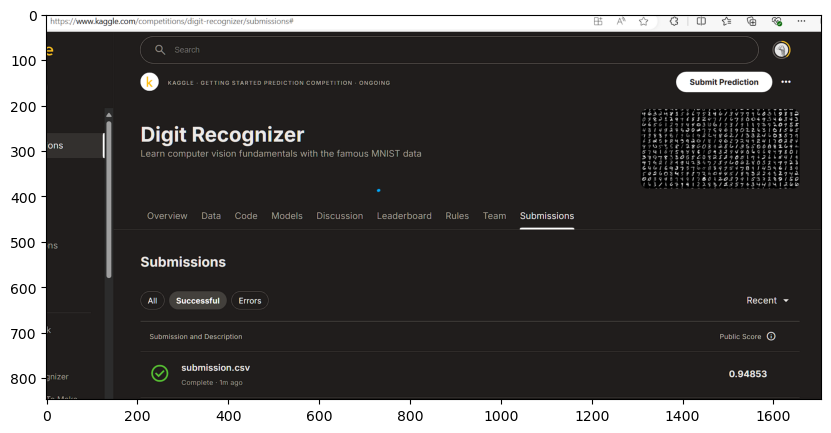

In [22]:
plt.figure(figsize=(10,8))

plt.imshow(img)